### [OpenCV HighGUI documentation](https://docs.opencv.org/4.7.0/d7/dfc/group__highgui.html#ga122632e9e91b9ec06943472c55d9cda8)

### Import Statements

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [4]:
%matplotlib inline

## **Input from Mouse**

### *Mouse events* ([Documentation](https://docs.opencv.org/4.x/d0/d90/group__highgui__window__flags.html#gaab4dc057947f70058c80626c9f1c25ce))

Mouse event can be anything related to mouse like left-button down, left-button up, left-button double-click etc.

In [5]:
# list of all the available mouse event types and flags

mouse_events = [func for func in dir(cv) if func.startswith("EVENT")]

> The `cv.setMouseCallback(winname, onMouse, userdata = 0)` function is used to **call a specific function (onMouse) when any mouse event takes place on a specific window (winname)**.

This function monitors a specific window for mouse events (see the docs for the available mouse event flags and types). When a mouse event takes place it calls the callback function with the event type and the event coordinates (x,y).

<u>Function Parameters:</u>
- winname: Name of the window which is observed for any mouse event.
- onMouse: Callback function for mouse events.
- userdata: The optional parameter passed to the callback function. 

> Defining the `callback function`

The callback function has a specific format as to what argument it takes. The function can vary widely about what it does with the inputs but the inputs are to be provided in a specific sequence and format.

The callback function takes 5 arguments. A demo of such a function is provided below,

    def onMouse(event, x, y, flags, userdata):
        # function body
        return something

<u>Function Parameters</u>

- event: **one** of the cv MouseEventTypes constants.
- x: The x-coordinate of the mouse event.
- y: The y-coordinate of the mouse event.
- flags: **one** of the cv MouseEventFlags constants.
- userdata:	Optional parameter. User data that is passed as is to the callback.

**`Note:`** When the setMouseCallback calls the onMouse function we don't need to specify any of the function parameter values since it will automatically pass these parameter values. But if we want to pass on some information that we want to use inside the callback function we can pass them as the argument to 'userdata' (by default set to 0).

> So, the whole process goes as follows,

1. First we create a mouse-event callback function.
2. Next we choose which window we want to bind the callback function to (windows are reffered to by their names). After we've decided we bind the chosen window to the callback function using cv.setMouseCallback().

### *Recording mouse movements: A basic example of handling mouse events*

> Here we have a simple callback function that can be used to record mouse movements. The recording is initiated when the left mouse button is double clicked and ends when the left mouse button is released.

In [6]:
def simple_callback(event, x, y, flags, userdata):
    # we need to use global variables otherwise everytime a mouse event occurs, the variables will be initialized
    # a new and the last state won't be saved.

    # That's why if we define "is_left_down = False" inside the function block the mouse movements will not be
    # captured since in case of a mouse event where the mouse moves, the 'is_left_down' will always be false.

    # is_left_down = False

    global is_left_down, mouseX_mouseY

    # double clicking the left button is a requirement for the mouse movements to be stored in an array
    if event == cv.EVENT_LBUTTONDBLCLK:
        is_left_down = True
        print(f"Left button double clicked at: {(x, y)}")

    if event == cv.EVENT_LBUTTONUP:
        is_left_down = False
        print(f"Left button click released at: {x, y}")

    if is_left_down is True and event == cv.EVENT_MOUSEMOVE:
        mouseX_mouseY.append((x, y))

    return mouseX_mouseY

In [7]:
# global variables that would be used in the callback function
# we define them here because otherwise the variables will have values from the previous run instead of being
# initialized a new.
is_left_down = False
mouseX_mouseY = []

# The function namedWindow() creates a window that can be used as a placeholder for images and trackbars.
# Created windows are referred to by their names.
# If a window with the same name already exists, the function does nothing.
cv.namedWindow("image")

# the image to show on the binded window
img = np.zeros((640, 480), dtype=np.uint8)

# binding the window named 'image' to the mouse callback
cv.setMouseCallback("image", simple_callback)

# showing the image on the binded window 'image'
while True:
    cv.imshow("image", img)
    keyboad_input = cv.waitKey(1000)
    if keyboad_input == ord("q"):
        break

cv.destroyAllWindows()

Left button click released at: (100, 226)
Left button click released at: (152, 252)
Left button click released at: (113, 113)
Left button double clicked at: (113, 113)
Left button click released at: (108, 250)
Left button click released at: (156, 124)
Left button click released at: (156, 124)
Left button double clicked at: (156, 124)
Left button click released at: (159, 301)
Left button click released at: (83, 240)
Left button double clicked at: (83, 240)
Left button click released at: (172, 243)


In [8]:
pts = np.array(mouseX_mouseY, dtype=np.int32)

In [9]:
pts = pts.reshape(pts.shape[0], 1, 2)

In [10]:
canvas = img.copy().astype(np.uint8)

In [11]:
cv.polylines(canvas, [pts], isClosed=False, color=(200), thickness=2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

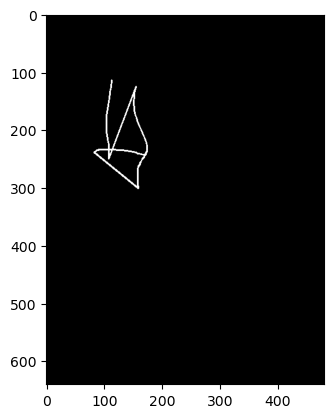

In [12]:
plt.imshow(canvas, "gray")

**`Note:`** The straight lines are due to drawing with polylines. Once the left button is released the program stops collecting mouse movements. Which is all good. But the problem is when we double click at another position to start tracking again, those movements are appended to the same list as before. As a result when drawing with polylines, the intermediary stops aren't recognized. To avoid this we can use the drawing function inside the callback function itself. 

### *Mouse as a paintbrush*

In [11]:
class Queue:
    def __init__(self):
        self.queue = []

    def enqueue(self, item):
        return self.queue.append(item)

    def dequeue(self):
        return None if len(self.queue) == 0 else self.queue.pop(0)

    def read(self):
        return None if len(self.queue) == 0 else self.queue[0]

In [12]:
def paint(event, x, y, flags, userdata):
    # a global variable that stores whether the left button was double clicked, a global variable for storing
    # whether left button is still clicked down, and another for initiating Queue which will store points
    # over which the mouse was dragged.
    # The "pts" is declared as a global variable. Otherwise it wouldn't be accessible outside of the pass
    # where it was initiated and would've thrown a "local variable not accessible" error.
    global is_left_double_clicked, is_left_down, pts

    if event == cv.EVENT_LBUTTONDBLCLK:
        # an array to capture all the points over which the mouse left button was dragged
        # it is initialized when the left button is double clicked
        pts = Queue()
        print(f"Left button double clicked at: {(x, y)}")
        is_left_double_clicked = True
        is_left_down = True

    if is_left_double_clicked and event == cv.EVENT_LBUTTONUP:
        print(f"Left button double click released at: {(x, y)}")
        is_left_down = False
        is_left_double_clicked = False

    if is_left_down and event == cv.EVENT_MOUSEMOVE:
        if pts.read() is None:
            pts.enqueue((x, y))

        else:
            previous_point = pts.dequeue()
            latest_point = (x, y)
            pts.enqueue(latest_point)
            # print(pts.read())

            # since the function is called on a known window we have access to the image that is displayed
            # on that window
            cv.line(img, previous_point, latest_point, 255, 3)

In [13]:
# initialize global variables
is_left_double_clicked = False
is_left_down = False

# create window that will be bound to the getMouseCallback
img = np.zeros((300, 600), dtype=np.uint8)

# bind getMouseCallback to a named window
cv.namedWindow("Image")
cv.setMouseCallback("Image", paint)

while True:
    cv.imshow("Image", img)

    keyboad_input = cv.waitKey(100)

    # press "q" or "Esc" to quit
    if keyboad_input == ord("q"):
        break

cv.destroyAllWindows()

Left button double clicked at: (190, 61)
Left button double click released at: (188, 64)
Left button double clicked at: (233, 133)
Left button double click released at: (314, 217)


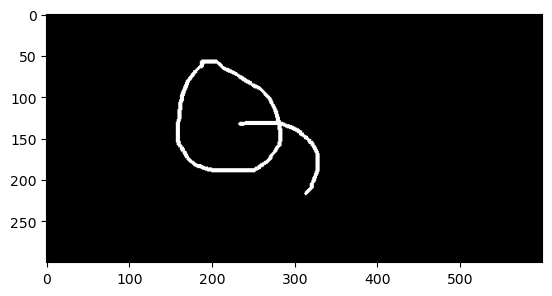

In [14]:
plt.imshow(img, "gray")

## **Creating Trackbars**

> The `cv.createTrackbar(trackbarname, winname, value, count, onChange=0, userdata=0)` is used to create a trackbar and attach it to the specified window

<u>Function Parameters:</u>
- trackbarname: name of the created trackbar, the name with which to refer to a particular trackbar.
- winname: the window to which the trackbar is attached.
- value: the default value with which the trackbar is initiated. Upon creation the slider position is defined by this variable.
- count: maximal position of the slider. The minimal position is always 0. 
- onChange:  the function to be called every time the slider changes position.
- userdata: User data that is passed as is to the callback. It can be used to handle trackbar events without using global variables.

> Defining the `callback function`

The callback function should be prototyped as, 

    def trackbar_callback(pos, userdata=0):
        # function body: do something
        return something
     
where the first parameter is the trackbar position (passed automatically to the function when trackbar position changes i.e, when the function is called) and the second parameter is the user data.

- To get the trackbar position at any instance we can also use the `cv.getTrackbarPos(trackbarname, winname)` function.

### *RGB color mixer: A basic example of using Trackbars*

> Here we have a simple callback function that can be used to show the RGB color output for a particular combination of R, G and B values. The values can be changed using 3 separate trackbars.

> Another important application of trackbar is to use it as a button or switch. OpenCV, by default, doesn't have button functionality. So you can use trackbar to get such functionality. In our program, we have created one switch in which application works only if switch is ON (default), otherwise output screen is always black.

In [15]:
# the trackbar callback function
def trackbar_callback(pos, userdata={"on": True}):
    on = userdata.get("on")

    if cv.getTrackbarPos("ON/OFF", "Image") == 0:
        on = False

    # since the function is called on a known window we can access the image displayed on that window

    # if off then show a black image
    if not on:
        img[:, :, :] = np.zeros((300, 600, 3), dtype=np.uint8)
        return img

    else:
        r = cv.getTrackbarPos("R", "Image")
        g = cv.getTrackbarPos("G", "Image")
        b = cv.getTrackbarPos("B", "Image")

        img[:, :, :] = b, g, r
        return img

In [16]:
# first we create a window to which the trackbars will be attached
cv.namedWindow("Image")

# default view
img = np.zeros((300, 600, 3), dtype=np.uint8)

# creating the trackbars
cv.createTrackbar("R", "Image", 0, 255, trackbar_callback)
cv.createTrackbar("G", "Image", 0, 255, trackbar_callback)
cv.createTrackbar("B", "Image", 0, 255, trackbar_callback)

# by default the ON/OFF switch is ON
cv.createTrackbar("ON/OFF", "Image", 1, 1, trackbar_callback)


# showing the output in an infinite loop
while True:
    cv.imshow("Image", img)
    keyboad_input = cv.waitKey(10)
    if keyboad_input == ord("q"):
        break

cv.destroyAllWindows()

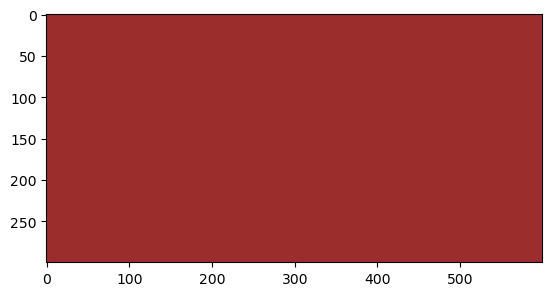

In [17]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))